In [35]:
!pip install -q segmentation_models_pytorch
!pip install -qU wandb

In [61]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
from matplotlib.patches import Rectangle
# import joblib
from collections import defaultdict
import gc
# from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Albumentations for augmentations
import albumentations as A

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import wandb
import segmentation_models_pytorch as smp


In [37]:
api_key = "5793e9c9290a2733cb520d9e4f5fa0dfa4e6284f" #my api
wandb.login(key=api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Configuration

In [38]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    model_name    = 'Unet'
    backbone      = 'efficientnet-b1'
    train_bs      = 128
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 10
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    fold          = 0
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
np.random.seed(CFG.seed)
random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed(CFG.seed)
# When running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Set a fixed value for the hash seed
os.environ['PYTHONHASHSEED'] = str(CFG.seed)

In [42]:
image_base_path = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
mask_base_path  = "/kaggle/input/uwmgi-mask-dataset"
df = pd.read_csv(mask_base_path + "/train.csv")
df["segmentation"] = df["segmentation"].notna() 
df["mask_path"] = df["mask_path"].str.replace("/png/", "/np").str.replace(".png", ".npy")
df = df.groupby(["id"]).head(1).reset_index(drop = True)
segmented, unsegmented = df['segmentation'].value_counts()
print(f"There are {segmented} segmented slices")
print(f"There are {unsegmented} unsegmented slices")

There are 24411 segmented slices
There are 14085 unsegmented slices


In [43]:
df.head(5)

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path
0,case123_day20_slice_0001,large_bowel,False,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
1,case123_day20_slice_0002,large_bowel,False,123,20,2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
2,case123_day20_slice_0003,large_bowel,False,123,20,3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
3,case123_day20_slice_0004,large_bowel,False,123,20,4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
4,case123_day20_slice_0005,large_bowel,False,123,20,5,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...


In [44]:
def load_img(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype("float32")
    img = img / np.max(img)
    return img

def load_msk(mask_path_npy):
    mask = np.load(mask_path_npy)
    mask = mask.astype("float32")
    mask = mask / 255.0
    return mask

In [45]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['segmentation'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','segmentation'])['id'].count())

fold  segmentation
0.0   False           4577
      True            2655
1.0   False           5225
      True            3303
2.0   False           5161
      True            2775
3.0   False           4841
      True            2503
4.0   False           4607
      True            2849
Name: id, dtype: int64

In [46]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

# Build dataset for model

In [47]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)
        
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

## Build DataLoader

In [48]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5).query("segmentation==True")
        valid_df = valid_df.head(32*3).query("segmentation==True")
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader


In [49]:
train_loader, valid_loader = prepare_loaders(fold=0, debug=True)

In [50]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([20, 3, 224, 224]), torch.Size([20, 3, 224, 224]))

## Visualization

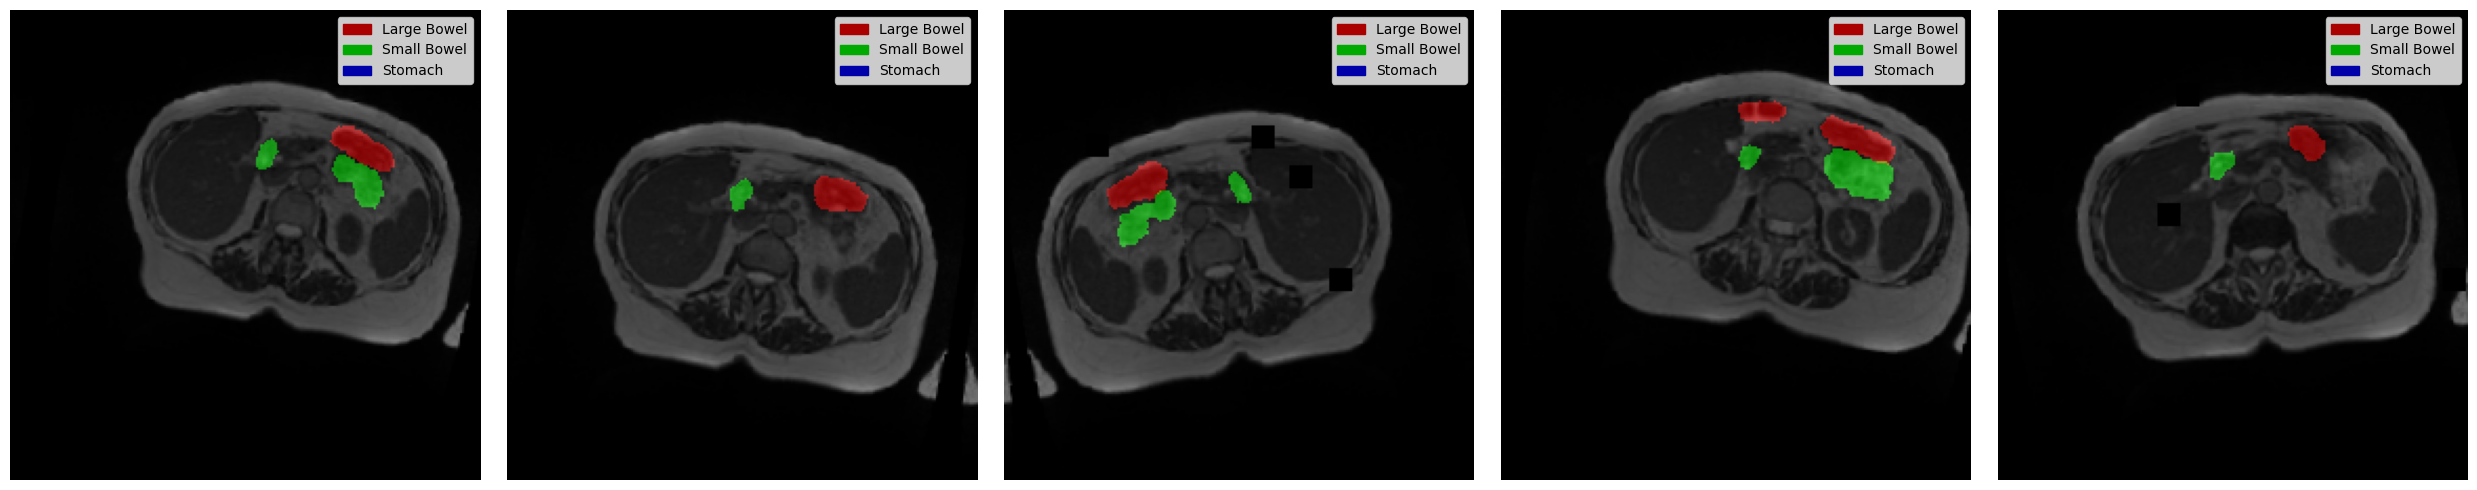

In [51]:
def visualize_batch(imgs = imgs, msks = msks, num=5):
    '''
    Parameters:
    imgs: Tensor
    msks: Tensor
    num: number images that you want to plot.
    '''
    plt.figure(figsize=(5*5, num))
    for idx in range(num):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0 
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        plt.imshow(img, cmap='bone')    
        plt.imshow(msk, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_batch()

In [52]:
import gc
gc.collect()

20716

## Model


In [53]:
def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

## Loss Function

In [54]:
def criterion(y_pred, y_true):
    BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
    TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

In [55]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    '''
    If the forward pass for a particular op has float16 inputs, the backward pass for that op will
    produce float16 gradients. Gradient values with small magnitudes may not be representable in float16. 
    These values will flush to zero (“underflow”), so the update for the corresponding parameters will be
    lost. 
    To prevent underflow, “gradient scaling” multiplies the network’s loss(es) by a scale factor and invokes
    a backward pass on the scaled loss(es). Gradients flowing backward through the network are then scaled by
    the same factor. In other words, gradient values have a larger magnitude, so they don’t flush to zero.
    '''
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
                # Enables autocasting for the forward pass (model + loss)
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
        # Exits the context manager before backward() 
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            '''
            All optimizers implement a step() method, that updates the parameters.This is a simplified version supported by most optimizers. 
            The function can be called once the gradients are computed using e.g. backward().
            '''
            scaler.step(optimizer)
            '''
            update()
            Updates the scale factor.
            If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it.
            If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor
            to increase it.
            Passing new_scale sets the new scale value manually. (new_scale is not used directly, it’s used to
            fill GradScaler’s internal scale tensor. So if new_scale was a tensor, later in-place changes to that
            tensor will not further affect the scale GradScaler uses internally.)
            '''
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        '''  
        torch.cuda.memory_reserved()
        Returns the current GPU memory managed by the caching allocator in bytes for a given device.
        '''       
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    '''
    torch.cuda.empty_cache()
    Releases all unoccupied cached memory currently held by the caching allocator so that those
    can be used in other GPU application and visible in nvidia-smi.
    '''
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

In [56]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    torch.cuda.empty_cache()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_iou = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_iou])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [57]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_iou = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid IOU'].append(val_iou)
        
        # Log the metrics
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid IOU": val_iou,
                   "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid IOU: {val_iou:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            best_dice = val_dice
            best_iou = val_iou
            best_epoch = epoch
            run.summary["Best Dice"]    = best_dice
            run.summary["Best IOU"] = best_iou
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"best_epoch-{fold:02d}.bin")
            # Save a model file from the current directory
            wandb.save( f"best_epoch-{fold:02d}.bin")
            print(f"Model Saved{sr_}")
        last_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), f"last_epoch-{fold:02d}.bin")
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(max(best_iou, best_dice)))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# Build Dice, IOU function

In [58]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

In [62]:
fold = 4
run = wandb.init(project="improved UNET", 
                 config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                 name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}"
                )
train_loader, valid_loader = prepare_loaders(fold=fold, debug= CFG.debug)
model     = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, eta_min=CFG.min_lr)
model, history = run_training(model, optimizer, scheduler,
                              device=CFG.device,
                              num_epochs=CFG.epochs)

run.finish()

cuda: Tesla P100-PCIE-16GB

Epoch 1/10

Valid : 100%|██████████| 30/30 [00:47<00:00,  1.60s/it, gpu_memory=9.01 GB, lr=0.00036, valid_loss=0.3728]


Valid Dice: 0.5031 | Valid IOU: 0.4704
Model Saved
Epoch 2/10

Valid : 100%|██████████| 30/30 [00:23<00:00,  1.27it/s, gpu_memory=9.02 GB, lr=0.00119, valid_loss=0.2885]


Valid Dice: 0.6576 | Valid IOU: 0.6213
Model Saved
Epoch 3/10

Valid : 100%|██████████| 30/30 [00:23<00:00,  1.25it/s, gpu_memory=9.02 GB, lr=0.00188, valid_loss=0.1638]


Valid Dice: 0.8514 | Valid IOU: 0.8196
Model Saved
Epoch 4/10

Valid : 100%|██████████| 30/30 [00:23<00:00,  1.28it/s, gpu_memory=9.04 GB, lr=0.00007, valid_loss=0.1283]


Valid Dice: 0.8700 | Valid IOU: 0.8393
Model Saved
Epoch 5/10

Valid : 100%|██████████| 30/30 [00:23<00:00,  1.29it/s, gpu_memory=9.02 GB, lr=0.00069, valid_loss=0.1353]


Valid Dice: 0.8781 | Valid IOU: 0.8469
Model Saved
Epoch 6/10

Valid : 100%|██████████| 30/30 [00:23<00:00,  1.26it/s, gpu_memory=9.03 GB, lr=0.00154, valid_loss=0.1292]


Valid Dice: 0.8821 | Valid IOU: 0.8519
Model Saved
Epoch 7/10

Valid : 100%|██████████| 30/30 [00:23<00:00,  1.27it/s, gpu_memory=9.04 GB, lr=0.00199, valid_loss=0.1240]


Valid Dice: 0.8783 | Valid IOU: 0.8478
Epoch 8/10

Valid : 100%|██████████| 30/30 [00:22<00:00,  1.30it/s, gpu_memory=9.03 GB, lr=0.00027, valid_loss=0.1247]


Valid Dice: 0.8793 | Valid IOU: 0.8486
Epoch 9/10

Valid : 100%|██████████| 30/30 [00:23<00:00,  1.27it/s, gpu_memory=9.04 GB, lr=0.00106, valid_loss=0.1258]


Valid Dice: 0.8898 | Valid IOU: 0.8604
Model Saved
Epoch 10/10

Valid : 100%|██████████| 30/30 [00:25<00:00,  1.18it/s, gpu_memory=9.03 GB, lr=0.00181, valid_loss=0.1207]


Valid Dice: 0.8915 | Valid IOU: 0.8615
Model Saved
Training complete in 0h 55m 9s
Best Score: 0.8915


LR,▂▅█▁▃▆█▂▅▇
Train Loss,█▅▂▂▁▁▁▁▁▁
Valid Dice,▁▄▇███████
Valid IOU,▁▄▇███████
Valid Loss,█▆▂▁▁▁▁▁▁▁
Best Dice,0.89146
Best Epoch,10
Best IOU,0.86151
LR,0.00181
Train Loss,0.10238
Valid Dice,0.89146


## Prediction

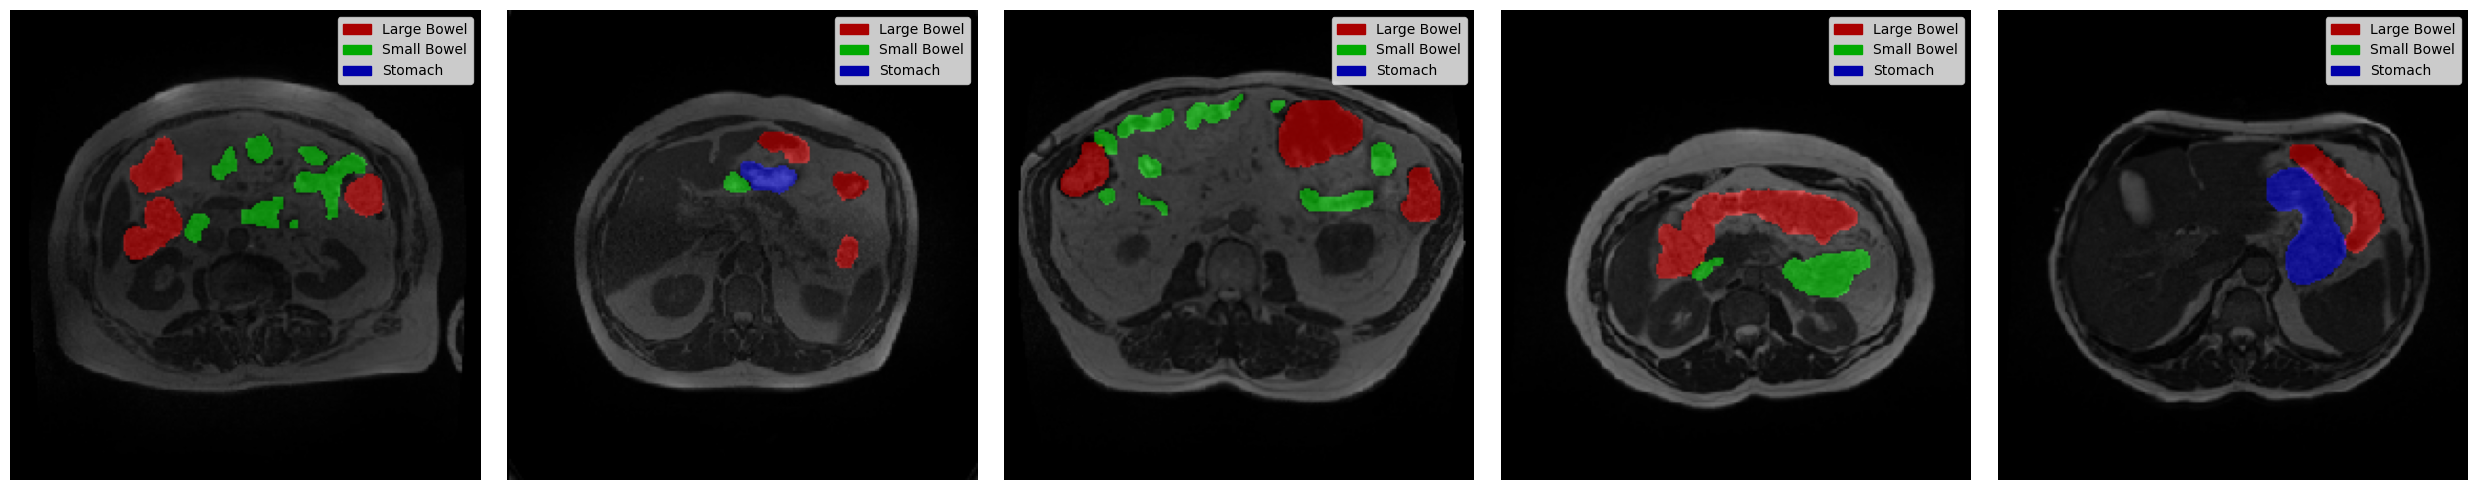

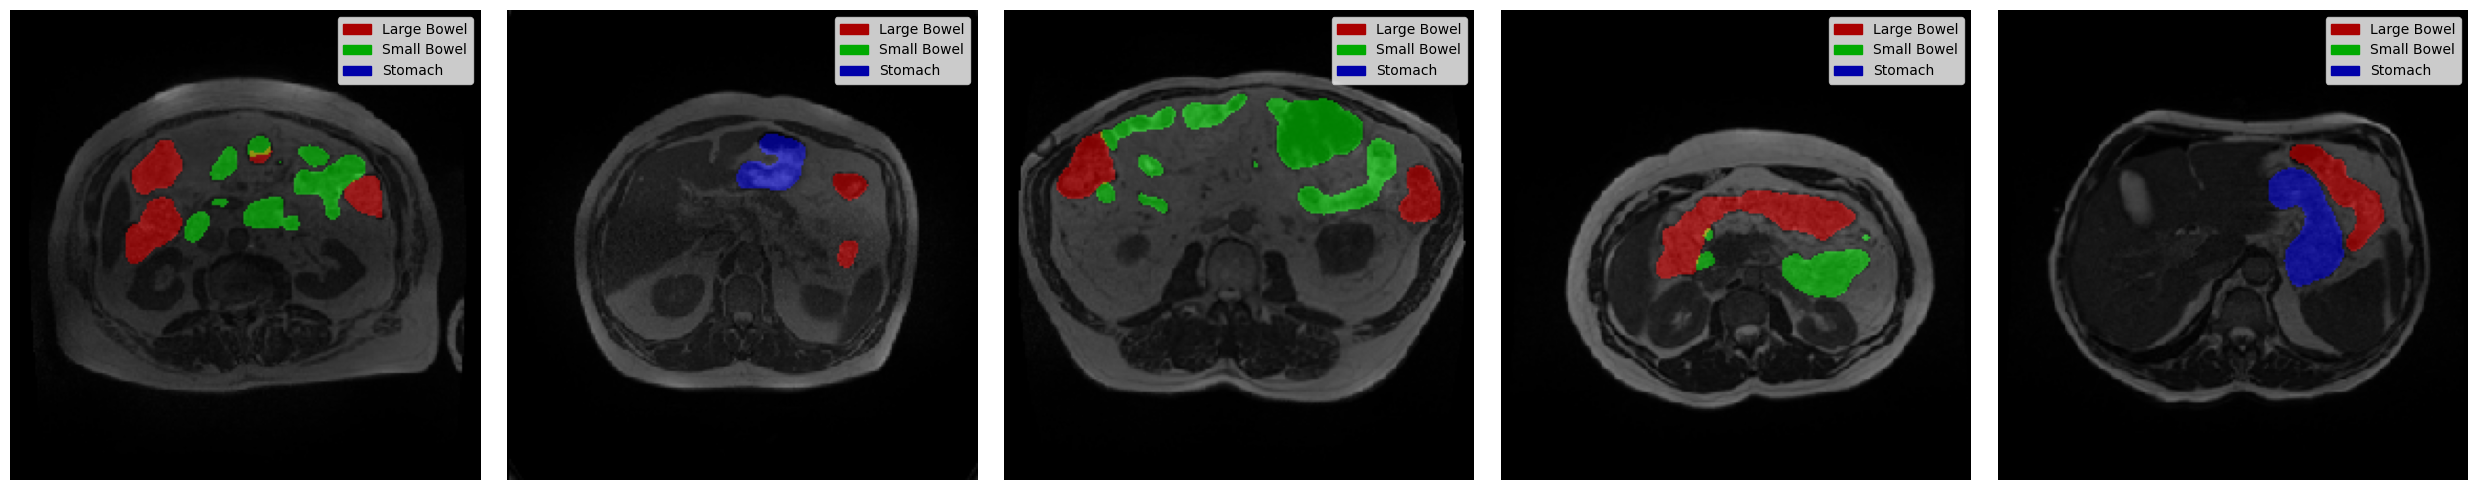

In [63]:
test_dataset = BuildDataset(df.query("fold==@fold & segmentation==True").sample(frac=1.0), label=True, 
                            transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs, msks = next(iter(test_loader))
visualize_batch(imgs, msks)
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []

model = load_model(f"last_epoch-{fold:02d}.bin")
with torch.no_grad():
    pred = model(imgs)
    pred = (nn.Sigmoid()(pred)>0.5).double()
preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()
visualize_batch(imgs, preds)

In [64]:
# !rm -r /kaggle/working/last_epoch-04.bin